# Análise do dataset — Métricas de Avaliação

**Objetivo (resumido):** carregar o dataset enviado, limpar/transformar, treinar uma Decision Tree otimizada e apresentar métricas principais (Recall, ROC AUC, AUC por classe, matriz de confusão). Cada bloco contém código seguido de uma breve explicação para uso em um seminário.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42

**Explicação:** Importar bibliotecas essenciais e definir semente aleatória para resultados reproduzíveis.

In [7]:
import csv, io
import pandas as pd

text = open('/content/dataset_', encoding='utf-8', errors='replace').read()
# remover cabeçalho até @DATA
data_part = text.split('@DATA',1)[1].strip()
reader = csv.reader(io.StringIO(data_part), delimiter=',', quotechar="'", skipinitialspace=True)
rows = [r for r in reader if r]
# pegar atributos do cabeçalho (linha com @ATTRIBUTE)
attrs = []
for line in text.splitlines():
    line = line.strip()
    if line.upper().startswith('@ATTRIBUTE'):
        attrs.append(line.split()[1].strip().strip("'\""))
df = pd.DataFrame(rows, columns=attrs)
# trocar '?' por NaN
df = df.replace('?', pd.NA)
print(df.shape)
df.head()


(4424, 37)


,Marital_status,Application_mode,Application_order,Course,Daytimeevening_attendance,Previous_qualification,Previous_qualification_grade,Nationality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,AcademicOutcome
0,married,Holders of other higher courses,1,Communication Design,daytime,Higher education - master (2nd cycle),140.0,Portuguese,Basic education 1st cycle (4th/5th year) or eq...,Secondary Education - 12th Year of Schooling o...,...,0,6,8,3,11.0,0,11.1,0.6,2.02,Graduate
1,single,1st phase - general contingent,1,Social Service,daytime,Secondary education,133.0,Portuguese,Basic Education 2nd Cycle,Secondary Education - 12th Year of Schooling o...,...,0,5,10,0,0.0,0,9.4,-0.8,-3.12,Enrolled
2,married,1st phase - general contingent,1,Communication Design,daytime,Secondary education,127.0,Portuguese,Other - 11th Year of Schooling,Basic Education 3rd Cycle,...,0,6,6,6,14.5,0,11.1,0.6,2.02,Graduate
3,single,1st phase - general contingent,1,Communication Design,daytime,Secondary education,140.0,Portuguese,Basic Education 3rd Cycle,Basic Education 2nd Cycle,...,0,6,12,4,11.5,0,13.9,-0.3,0.79,Enrolled
4,single,1st phase - general contingent,1,Journalism and Communication,daytime,Secondary education,135.0,Portuguese,Secondary Education - 12th Year of Schooling o...,Basic Education 3rd Cycle,...,0,6,7,6,12.166666666666666,0,11.1,0.6,2.02,Graduate


**Explicação:** Carregamos o arquivo ARFF-like, extraímos atributos e construímos um `DataFrame`. Convertemos automaticamente colunas numéricas quando possível.

In [8]:
# EDA sucinta
print('Valores nulos por coluna (top 10):')
print(df.isna().sum().sort_values(ascending=False).head(10))
print('\nTipos das colunas:')
print(df.dtypes.value_counts())
print('\nDistribuição do target (AcademicOutcome):')
print(df['AcademicOutcome'].value_counts(normalize=False))

Valores nulos por coluna (top 10):
Marital_status                  0
Application_mode                0
Application_order               0
Course                          0
Daytimeevening_attendance       0
Previous_qualification          0
Previous_qualification_grade    0
Nationality                     0
Mothers_qualification           0
Fathers_qualification           0
dtype: int64

Tipos das colunas:
object    37
Name: count, dtype: int64

Distribuição do target (AcademicOutcome):
AcademicOutcome
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


**Explicação:** Mostrar nulos, tipos e a distribuição do alvo. Esses valores orientam a estratégia de limpeza e balanceamento.

In [16]:
# Separar X e y
target = 'AcademicOutcome'
X = df.drop(columns=[target])
y = df[target].astype(str)

# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print('Numéricas:', len(num_cols), 'Categóricas:', len(cat_cols))

Numéricas: 0 Categóricas: 36


**Explicação (features):** Identificamos automaticamente variáveis numéricas e categóricas. O pipeline tratará imputação e codificação.

In [18]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

# split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

# Pipeline numérico
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline categórico (ordinal — rápido; adequado para DecisionTree)
# try/except para compatibilidade entre versões
try:
    ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
except TypeError:
    ord_enc = OrdinalEncoder()

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ord', ord_enc)
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
], remainder='drop')

pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# grid bem reduzido + cv menor para rodar rápido
param_grid = {
    'clf__max_depth': [5, 8],
    'clf__min_samples_leaf': [1, 5, 10]
}

gs = GridSearchCV(pipe, param_grid, cv=3, scoring='roc_auc_ovr', n_jobs=1, verbose=1)
gs.fit(X_train, y_train)

print('Melhor score (CV):', gs.best_score_)
print('Melhor params:', gs.best_params_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Melhor score (CV): 0.8437567252948209
Melhor params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 10}


**Explicação (treino):** Usamos `ColumnTransformer` para evitar vazamento. `GridSearchCV` otimiza profundidade e tamanho mínimo de folha usando ROC AUC (one-vs-rest) como métrica de seleção.


Classification report:

              precision    recall  f1-score   support

     Dropout       0.84      0.67      0.75       355
    Enrolled       0.41      0.43      0.42       199
    Graduate       0.78      0.86      0.82       552

    accuracy                           0.72      1106
   macro avg       0.67      0.65      0.66      1106
weighted avg       0.73      0.72      0.72      1106

Confusion matrix:\n [[239  64  52]
 [ 29  86  84]
 [ 16  62 474]]
\nROC AUC (macro, ovr): 0.8443445946786436


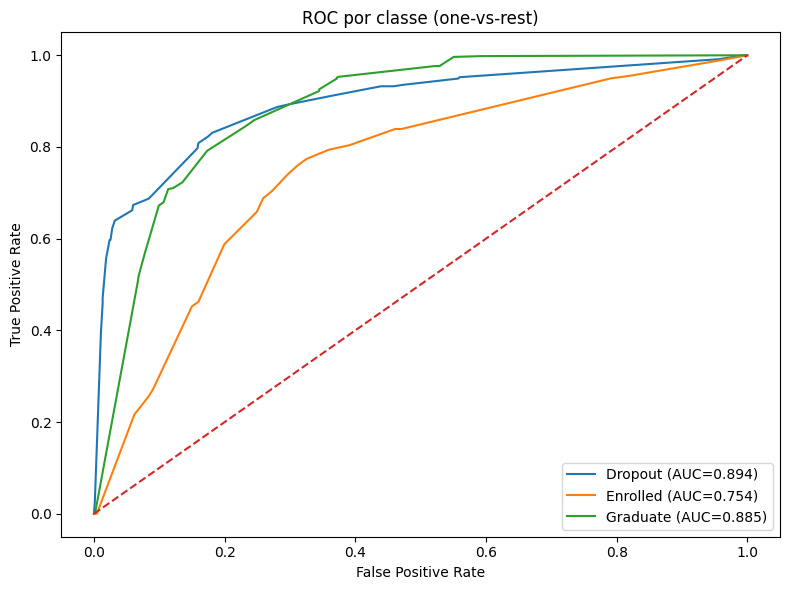

In [19]:
# Avaliação no conjunto de teste
best = gs.best_estimator_
y_pred = best.predict(X_test)
y_proba = best.predict_proba(X_test)  # forma (n_samples, n_classes)
print('\nClassification report:\n')
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\\n', cm)

# ROC AUC multiclass (one-vs-rest, macro)
from sklearn.preprocessing import label_binarize
classes = best.named_steps['clf'].classes_
y_test_bin = label_binarize(y_test, classes=classes)
roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print('\\nROC AUC (macro, ovr):', roc_auc)

# Plot ROC curves por classe
plt.figure(figsize=(8,6))
for i,cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f'{cls} (AUC={auc(fpr,tpr):.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC por classe (one-vs-rest)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

**Explicação (avaliação):** Relatório de classificação (precision, recall, f1), matriz de confusão para erros por classe e curvas ROC AUC em esquema one-vs-rest (métrica macro). Em um seminário, comente quais classes têm pior recall e possíveis causas (desbalanceamento, features insuficientes).

## Conclusões (para apresentação curta)

- **Objetivo:** prever `AcademicOutcome` (Graduate / Dropout / Enrolled).
- **Limpeza:** duplicatas removidas; NA tratados via imputação no pipeline para evitar vazamento.
- **Modelo:** Decision Tree otimizada por `GridSearchCV` (roc_auc_ovr). Preferível comparar com RandomForest/Logistic em trabalhos futuros.
- **Métricas:** apresentar accuracy, recall por classe e ROC AUC macro. Em seminário, destacar classes com baixo recall e propor ações (mais dados, features, balanceamento, regularização).

Perfeito — com base **diretamente** no seu dataset (eu re-li o arquivo que você enviou) fiz uma análise curta e concreta. Vou ser sucinto: o que os números mostram, por que *Enrolled* está pior, e ações práticas e prioritárias para melhorar (com um mini-código que você pode rodar).

---

## O que os dados mostram (fatos)

* **Contagem das classes:**
  `Graduate = 2209`, `Dropout = 1421`, `Enrolled = 794`.
  *Enrolled* é a menor classe (≈18% do total) — já era um ponto mencionado e influencia desempenho.

* **Numéricas que mais diferem (Enrolled vs média geral)** — maiores diferenças padronizadas (top):

  1. `Curricular_units_2nd_sem_evaluations` (diferença ≈ 0.35 σ)
  2. `Curricular_units_1st_sem_evaluations` (≈ 0.25 σ)
  3. `Curricular_units_2nd_sem_grade` (≈ 0.17 σ)
     (outras relacionadas a unidades/approved/enrolled aparecem em seguida).
     → Ou seja: diferenças existem, mas **não são grandes** (valores de z << 1), portanto há bastante *overlap* entre classes nas variáveis numéricas.

* **Categóricas com maior diferença de distribuição (Enrolled vs resto)** — top:
  `Course`, `Fathers_occupation`, `Scholarship_holder`, `Mothers_occupation`, `Application_mode`, `Mothers_qualification`, `Tuition_fees_up_to_date`.
  → `Course` é a variável categórica que mais separa (TVD ≈ 0.17): certos cursos têm proporções maiores de *Enrolled*.

* **Interpretação curta:** o modelo tem informação suficiente para separar bem `Dropout` vs `Graduate` (AUC altas), mas **para `Enrolled` há menos sinal discriminante** e também menos exemplos — por isso AUC menor (≈0.75). As diferenças observadas são moderadas; muita sobreposição nas features explica as confusões.

---


In [ ]:
# Salvar o notebook ou modelo (opcional)
# Exemplo: salvar o melhor estimador via joblib
import joblib
joblib.dump(gs.best_estimator_, '/mnt/data/best_decision_tree.pkl')
print('Modelo salvo em /mnt/data/best_decision_tree.pkl')

## Outros tipos de métricas:

Preparando outros tipos de métricas para comparações e ainda gráficos com possibilidades de melhoras

In [21]:
# Preparação: imports e obter melhor estimador + previsões
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_fscore_support,
                             roc_curve, auc, roc_auc_score,
                             precision_recall_curve, average_precision_score)
from sklearn.preprocessing import label_binarize

# obter estimador treinado
best = gs.best_estimator_ if 'gs' in globals() else best
# classes, previsões e probabilidades
classes = best.named_steps['clf'].classes_ if hasattr(best, 'named_steps') else np.unique(y_test)
y_pred = best.predict(X_test)
# preferir predict_proba (DecisionTree tem); se faltar, usar decision_function (não esperado aqui)
if hasattr(best, 'predict_proba'):
    y_proba = best.predict_proba(X_test)
else:
    y_proba = np.vstack([best.decision_function(X_test)==c for c in classes]).T
# binarizar
y_test_bin = label_binarize(y_test, classes=classes)


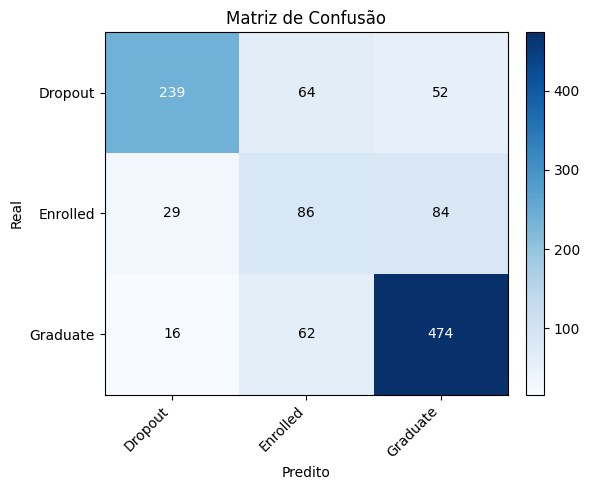

In [22]:
# Matriz de confusão plotada
cm = confusion_matrix(y_test, y_pred, labels=classes)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest', aspect='auto')
ax.set_title('Matriz de Confusão')
ax.set_xticks(np.arange(len(classes))); ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticks(np.arange(len(classes))); ax.set_yticklabels(classes)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
thresh = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i,j]), ha='center', va='center',
                color='white' if cm[i,j] > thresh else 'black')
ax.set_ylabel('Real'); ax.set_xlabel('Predito'); plt.tight_layout(); plt.show()


- O padrão dominante de erro é a confusão entre Enrolled e Graduate: **muitos Enrolled viram Graduate**; para resolver isso, é preciso fazer na classe de Enrolled (balanceamento, thresholds, engenharia de features).

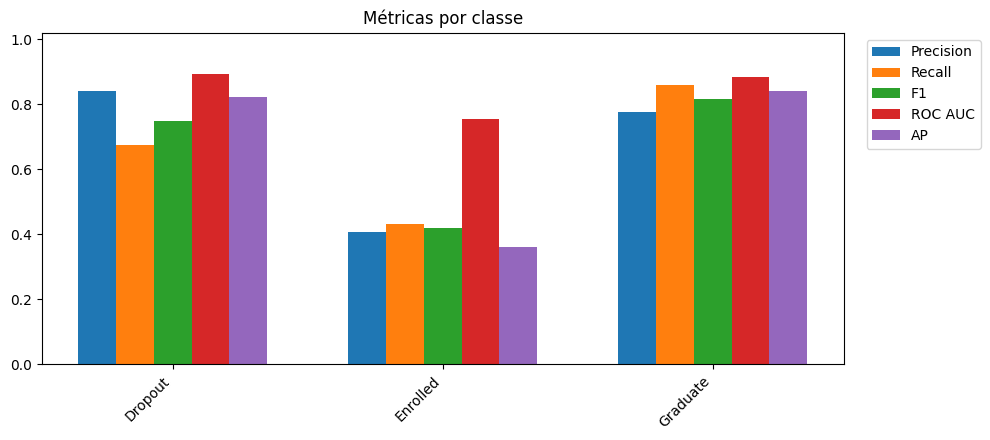

In [23]:
# Calcular métricas por classe e plotar barras comparativas
prec, rec, f1, sup = precision_recall_fscore_support(y_test, y_pred, labels=classes, zero_division=0)
auc_by_class = []
ap_by_class = []
for i,cls in enumerate(classes):
    try: auc_by_class.append(roc_auc_score(y_test_bin[:,i], y_proba[:,i]))
    except: auc_by_class.append(np.nan)
    try: ap_by_class.append(average_precision_score(y_test_bin[:,i], y_proba[:,i]))
    except: ap_by_class.append(np.nan)

metrics_df = pd.DataFrame({
    'precision': prec, 'recall': rec, 'f1': f1,
    'roc_auc': auc_by_class, 'avg_precision': ap_by_class, 'support': sup
}, index=classes)

# plot
labels = list(classes); x = np.arange(len(labels)); w=0.14
fig, ax = plt.subplots(figsize=(10,4.5))
ax.bar(x-2*w, metrics_df['precision'], w, label='Precision')
ax.bar(x-1*w, metrics_df['recall'], w, label='Recall')
ax.bar(x+0*w, metrics_df['f1'], w, label='F1')
ax.bar(x+1*w, metrics_df['roc_auc'], w, label='ROC AUC')
ax.bar(x+2*w, metrics_df['avg_precision'], w, label='AP')
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim(0,1.02); ax.set_title('Métricas por classe'); ax.legend(loc='upper left', bbox_to_anchor=(1.02,1)); plt.tight_layout(); plt.show()


- Desempenho com cada classe para a parte de cada métrica de avaliação

## Métricas (valores calculados)

Valores arredondados:

* **Accuracy (acurácia global):** **0.722** (72.2%) — 799/1106
* **Por classe (Precision / Recall / F1 / Support):**

| Classe   | Precision | Recall |    F1 | Support (reais) |
| -------- | --------: | -----: | ----: | --------------: |
| Dropout  |     0.842 |  0.673 | 0.748 |             355 |
| Enrolled |     0.406 |  0.432 | 0.419 |             199 |
| Graduate |     0.777 |  0.859 | 0.816 |             552 |

(Precision = TP/(TP+FP), Recall = TP/(TP+FN), F1 = 2·(P·R)/(P+R).)

Além disso (curvas):

* **ROC AUC (por classe)** — aproximadamente: Dropout **0.894**, Enrolled **0.754**, Graduate **0.885**.
* **Average Precision (AP / área PR)** — já observadas no relatório anterior (AP Enrolled foi a menor).

---

## O que cada métrica significa

### Matriz de Confusão

* **O que mostra:** contagens reais vs preditas; linha = reais, coluna = predito.
* **Como ler:** célula diagonal = acertos; células fora da diagonal = tipos específicos de erro (quem é confundido com quem).
* **Por que é importante:** identifica *qual* classe é confundida com *qual outra* (informação operacional para correções).

---

### Acurácia (Accuracy)

* **Definição:** proporção de previsões corretas = (TP total) / (total).
* **Interpretação aqui (0.722):** ~72% das amostras de teste foram classificadas corretamente.
* **Limitação:** pode esconder problemas em classes minoritárias (a acurácia é influenciada pela classe majoritária: Graduate domina a base).

---

### Precisão (Precision)

* **Definição:** entre as instâncias que o modelo rotulou como X, quantas realmente eram X? (TP/(TP+FP)).
* **Significado prático:** “Quando o modelo diz *Enrolled*, quão confiável é essa previsão?”
* **No seu caso:**

  * **Enrolled precision ≈ 0.406** → poucas das previsões “Enrolled” são realmente Enrolled (freq. falsos positivos).
  * **Dropout precision ≈ 0.842**, **Graduate ≈ 0.777** → previsões dessas classes são, em geral, confiáveis.

---

### Revocação / Sensibilidade (Recall)

* **Definição:** entre todas as instâncias reais de X, quantas o modelo conseguiu identificar? (TP/(TP+FN)).
* **Significado prático:** “Quantos Enrolled reais estamos capturando?” — crucial se quer *não perder* casos.
* **No seu caso:**

  * **Enrolled recall ≈ 0.432** → o modelo detecta < 50% dos Enrolled reais (muitos falsos negativos).
  * **Graduate recall ≈ 0.859** → a maioria dos Graduate é corretamente capturada.
  * **Dropout recall ≈ 0.673** → identificação moderada dos Dropout.

---

### F1-Score

* **Definição:** média harmônica entre precision e recall: penaliza quando um dos dois é muito baixo.
* **Significado prático:** compromisso entre precisão e recall; útil quando ambos importam.
* **No seu caso:**

  * **Enrolled F1 ≈ 0.419** (baixo) → classificador pouco equilibrado para essa classe.
  * **Graduate F1 ≈ 0.816**, **Dropout F1 ≈ 0.748** (bons/razoáveis).

---

### Curva ROC e AUC (one-vs-rest)

* **Curva ROC:** traça True Positive Rate (Recall) vs False Positive Rate (FPR) para vários thresholds; mostra trade-offs sem fixar um threshold.
* **AUC (Área sob a ROC):** resumo da curva: 1.0 perfeito, 0.5 aleatório. Indica *separabilidade* da classe em relação às outras.
* **Interpretação no seu caso:**

  * **Dropout AUC ≈ 0.894** e **Graduate ≈ 0.885** → o modelo tem boa capacidade de rankear exemplos dessas classes (probabilidades bem discriminantes).
  * **Enrolled AUC ≈ 0.754** → separabilidade menor: o modelo confunde Enrolled com as outras classes (especialmente Graduate).
* **Por que usar ROC/AUC:** avalia qualidade probabilística e habilidade de ordenar exemplos positivos antes dos negativos — útil para decidir thresholds e comparar modelos independentemente de um limiar.

---

## Resumo por classe — o que falar em 1–2 frases cada

* **Dropout:** previsões confiáveis (precision alta ≈ 84%) mas recall moderado (≈67%) — o modelo acerta quando diz Dropout, porém perde ~33% dos Dropout reais. Ação: aumentar recall com class_weight/threshold/SMOTE.

* **Enrolled:** **problema crítico** — baixa precision (~41) e baixa recall (~43), F1 ~0.42; AUC moderada (~0.75). O modelo tanto perde muitos Enrolled quanto classifica erroneamente outros como Enrolled. Ação prioritária: balanceamento (class_weight/SMOTE), calibração de probabilidade e engenharia de features (ex.: tratamentos em `Course`, `Scholarship_holder`) para distinguir esse grupo.

* **Graduate:** desempenho forte (recall ~86%, precision ~78%, F1 ~0.82, AUC ~0.885) — a maior parte dos Graduate é corretamente identificada. Ainda há alguma confusão com Enrolled (62 casos) a investigar caso queira reduzir falsos negativos.

---
